In [427]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score
# from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
# from sklearn.pipeline import make_pipeline
import itertools
import warnings
warnings.filterwarnings('ignore')

## Part A: Model code


### A: 2 Implement MSE 

In [409]:
mse = lambda y_true, y_pred : np.mean((y_true-y_pred)**2)

In [410]:
#sanity check
y_true = np.random.randint(10, size=(4,))
y_pred = np.random.randint(10, size=(4,))
print('y_true:', y_true)
print('y_pred:', y_pred)
print(mse(y_true, y_pred))

from sklearn import metrics
print('expected from sklearn', metrics.mean_squared_error(y_true, y_pred))

y_true: [3 5 8 2]
y_pred: [5 8 6 1]
4.5
expected from sklearn 4.5


### A: 5. Implement Linear_Regression class

**TODO:** Explain the math here

In [580]:
class Linear_Regression(object):
    def __init__(self):
        self.params = {} #save model weights
        
    def predict(self, X):
        return X.dot(self.params['w']).reshape(-1) #(N,D) dot (D,1) = (N,1)
    
    def loss(self, X, y):
        N, D = self.X.shape
        grads = {}#return gradient for Gradient descent update
        #forward pass
        scores = self.predict(X)

        #backward pass
        loss, dw = 0.0, None
        loss = (0.5/N) * np.sum((y-scores)**2)
        #get mse loss and dout here
        dout = (1/N) * (scores - y) 
        
        #y = wx + b -> dy/db = dout/dy * dy/db = dout * 1.0
        
        #dout/dw = dout/dy dot dy/dw = dout dot x
        #shape: (N,1) dot (N,D) -> X.T.dot(dout)
        dw = X.T.dot(dout).reshape(-1,1)
        
        #add regulirizer strength
        if self.regularizer is 'l2':
            loss += (self.lambd/N)*np.sum(self.params['w']**2)
            dw += (self.lambd/N)*self.params['w']
        elif self.regularizer is 'l1':
            loss += (self.lambd/N)*np.sum(self.param['w'])
            dw += (self.lambd/N)*(1/2) * (self.param['w']/np.abs(self.param['w'])) 
            

        return loss, dw
    def fit(self, X, Y, learning_rate=1e-1, 
                   epochs=300, tol=None, regularizer='l2',
                   lambd=0.0001, verbose=False):
        '''
        Inputs:
        - X: numpy array of inputs vector  (N, D)
        - Y: numpy array of target vector (N,)
        - learning_rate: float provide the step size
        - epochs: int provide number of passes through in dataset
        - tol: float or None provide the stopping criterion.
         iteration will stop when (loss > previous_loss - tol) 
         default to None
        - regularizer: string of 'l1' or 'l2'
        - lambd: float provide regularize coeff
        '''
        loss_hist = []
        self.X = X
        self.y = Y
        self.learning_rate = learning_rate
        self.regularizer = regularizer
        self.tol = tol
        self.lambd = lambd
        
        self.epochs = epochs
        
        N, D = self.X.shape
        
        self.params['w'] = np.random.randn(D,1)
        prev_loss = 0.0
        for e in range(self.epochs):
            loss, dw = self.loss(self.X, self.y)
            
            #SGD
            self.params['w'] -= learning_rate * dw
            
            if verbose and e % 20 == 0 : print('epoch', e, 'loss', loss)
            loss_hist.append(loss)#track the loss
            
            #early stopping
            if self.tol: 
                if loss > (prev_loss - tol):
                    break
            prev_loss = loss
        return loss_hist

Sanity check 

epoch 0 loss 6.612129284490074
epoch 20 loss 6.143170348190848
epoch 40 loss 5.994869002269797
epoch 60 loss 5.933088139163741
epoch 80 loss 5.895546288506724
epoch 100 loss 5.86562603812046
epoch 120 loss 5.838846264549204
epoch 140 loss 5.813954001572842
epoch 160 loss 5.790557453450194
epoch 180 loss 5.768496920755571
epoch 200 loss 5.747677478951667
epoch 220 loss 5.728024349240942
epoch 240 loss 5.709470876960665
epoch 260 loss 5.691955182580752
epoch 280 loss 5.675419125573911


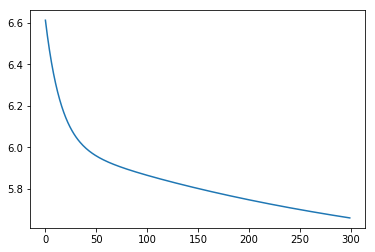

In [594]:
#sanity check
LR = Linear_Regression()
np.random.seed(10)
# x1 = np.linspace(0, 100, 1000) # 1000 values between 0 and 100
# # x = np.arange(-50, 50) # -50, -49, ... 49, 50
# delta = np.random.uniform(-10, 10, x1.size)
# x2 = 0.4*x1 + 3 + delta

X = np.random.uniform(-10, 10, size=(1000,2))
X[:,1] *= 0.2
y = np.random.randn(1000) * 3.3

loss_hist = LR.fit(X, y, learning_rate=1e-3, verbose=True)
plt.plot(loss_hist)

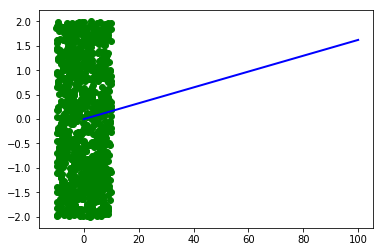

In [595]:
x = np.linspace(0,100,10)
LR.params['w'][0]
plt.plot(x,LR.params['w'][0]*x, 'b-', linewidth=2, markersize=12)
# # plt.plot(LR.params['w'][1]*x)
plt.scatter(X[:,0], X[:,1], c='g')

### A.1: Implement polynomialFeature function

In [460]:
def polynomialFeatures(X, degree):
    '''
    Arguments:

    X : ndarray 
        A numpy array with rows representing data samples and columns representing features (d-dimensional feature).

    degree : integer
        The degree of the polynomial features. Default = 1.

    Returns:

        A new feature matrix consisting of all polynomial combinations of the features with degree equal to the specified degree. 
        For example, if an input sample is two dimensional and of the form [a, b], 
        the degree-2 polynomial features are [a, b, a2, ab, b2].
    '''
    map_terms = {}
    poly_term = []
    result_term = []
    for i in range(X.shape[1]):
        map_terms[i] = X[:,i]
        poly_term.append(i)

    terms = get_polynomial(poly_term, degree)
    result = 1
    for sublst in terms:
        for x in sublst:
            if x == 'cons':
                result *= np.ones((X.shape[0],), dtype=int)
            else:
                result *= map_terms[x] 
                
        result_term.append(result)
        result = 1
    
    return np.array(result_term).T

def get_polynomial(vars, degree):

    vars.append("cons") # add dummy variable
    
    # compute all combinations of variables
    terms = []
    for x in itertools.combinations_with_replacement(vars, degree):
        terms.append(x)

    # get rid of "c" terms
    terms = map(list, terms)
    terms = list(terms)
 
    return terms

In [461]:
#sanity check
X = np.array([
    [2,3,4],
    [1,2,2]
])
y = np.array([0,3])

print('''
Example of get_polynomial() function.
This will return combinatoric of n between 2 variables''')
display(get_polynomial(['x1', 'x2', 'x3'], 3))
print("polynomial features")
print(polynomialFeatures(X, 2))

print('''
\n__________Expected from Sklearn________
Note: here our result does math with sklearn, 
order are mixed. but SGD keep order consistence
when training.
''')
poly = preprocessing.PolynomialFeatures(2)
poly.fit_transform(X)


Example of get_polynomial() function.
This will return combinatoric of n between 2 variables


[['x1', 'x1', 'x1'],
 ['x1', 'x1', 'x2'],
 ['x1', 'x1', 'x3'],
 ['x1', 'x1', 'cons'],
 ['x1', 'x2', 'x2'],
 ['x1', 'x2', 'x3'],
 ['x1', 'x2', 'cons'],
 ['x1', 'x3', 'x3'],
 ['x1', 'x3', 'cons'],
 ['x1', 'cons', 'cons'],
 ['x2', 'x2', 'x2'],
 ['x2', 'x2', 'x3'],
 ['x2', 'x2', 'cons'],
 ['x2', 'x3', 'x3'],
 ['x2', 'x3', 'cons'],
 ['x2', 'cons', 'cons'],
 ['x3', 'x3', 'x3'],
 ['x3', 'x3', 'cons'],
 ['x3', 'cons', 'cons'],
 ['cons', 'cons', 'cons']]

polynomial features
[[ 4  6  8  2  9 12  3 16  4  1]
 [ 1  2  2  1  4  4  2  4  2  1]]


__________Expected from Sklearn________
Note: here our result does math with sklearn, 
order are mixed. but SGD keep order consistence
when training.



array([[ 1.,  2.,  3.,  4.,  4.,  6.,  8.,  9., 12., 16.],
       [ 1.,  1.,  2.,  2.,  1.,  2.,  2.,  4.,  4.,  4.]])

### A: 4. IMplemeent plot polynomial model complexity

In [462]:
def plot_polynomial_model_complexity(model, X, Y, cv, 
                                     maxPolynomialDegree, 
                                     learning_rate=0.01, 
                                     epochs=1000, tol=None, 
                                     regularizer=None, lambd=0.0):
    '''
    Arguments:
        model : object type that implements the “fit” and “predict” methods. An object of that type which is 
        cloned for each validation.
        
        X: ndarray A numpy array with rows representing data samples and columns representing features.
        
        Y: ndarplot_polynomial_model_complexity(LinearRegression(), X_train, y_train, 5, 5, learning_rate=0.01,
        epochs=1000, tol=None, regularizer=None, lambd=0.0)ray A 1D numpy array with labels corresponding to 
        each row of the feature matrix X.
        
        cv : int integer, to specify the number of folds in a (Stratified) K-Fold,
        
        maxPolynomialDegree: int It will be used to determine the maximum polynomial degree for X. 
            For example, if it is set to 3, then the function will compute both the training and 
            validation mse values for degree 1, 2 and 3.
            
        learning_rate: float It provides the step size for parameter update.
        
        epochs: int The maximum number of passes over the training data for updating the weight vector.
        
        tol: float or None The stopping criterion. If it is not None, the iterations will stop when (error> 
        previous_error-tol).If it is None, the number of iterations will be set by the “epochs”.
            
        regularizer: string The string value could be one of the following: l1, l2, None. 
            If it’s set to None, the cost function without the regularization term will be used for computing 
            the gradientand updating the weight vector. However, if it’s set to l1 or l2, the appropriate 
            regularized cost function needs to be used for computing the gradient and updating the weight vector.
            
        lambd: float It provides theregularization coefficient.It is used only when the “regularizer” is set to l1 or l2.
        
    Returns:
        There is no return value. This function plots the root-mean-square error (rmse) values for both the training set 
        and the validation set for degree of X between 1 and maxPolynomialDegree.
    '''
    degree_list = []
    train_scores = []
    val_scores = []
    for i in range(1, maxPolynomialDegree + 1):
        degree_list.append(i)
        X_poly = polynomialFeatures(X, i)
    
        x_train_folds = np.array(np.array_split(X_poly, cv))
        y_train_folds = np.array(np.array_split(Y, cv))

        train_score = 0
        val_score = 0
        for idx, val_fold in enumerate(x_train_folds):
            train_folds = [f for i, f in enumerate(x_train_folds) if(i != idx)][0] #[0]: unpacking the outer list
            label_folds = [f for i, f in enumerate(y_train_folds) if(i != idx)][0]
            
            model.fit(train_folds, label_folds)

            train_pred = model.predict(train_folds)
            val_pred = model.predict(val_fold)

            train_score += mse(label_folds, train_pred)
            val_score += mse(y_train_folds[idx], val_pred)
            
        train_scores.append(train_score/cv)
        val_scores.append(val_score/cv)
        
    plt.figure(figsize=(10, 6))   
    plt.plot(degree_list, np.sqrt(val_scores), "ro-", 
             alpha=1.0, linewidth=1.0, label="Validation RMSE")
    plt.plot(degree_list, np.sqrt(train_scores), "bo-", 
             alpha=1.0, linewidth=1.0, label="Train RMSE")    
    plt.legend(loc="best", fontsize=14) 
    plt.xlabel("Degree")
    plt.ylabel("RMSE")
    plt.title("RMSE for Varying Degree")
    plt.show()
    return train_scores, val_scores

_____________Implemented___________


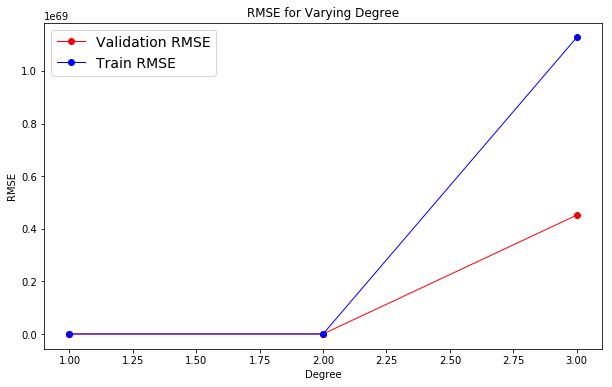


______________Sklearn_______________


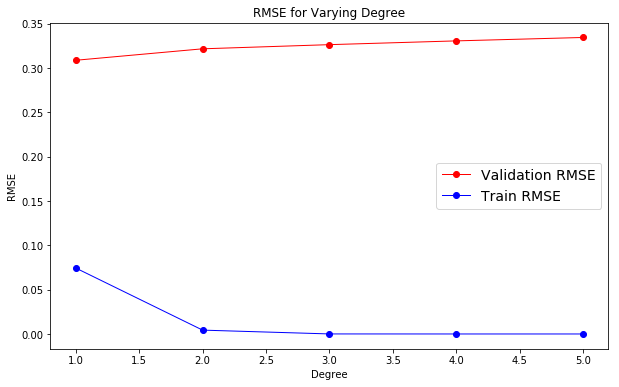

In [597]:
X_train_ = np.random.rand(10,10)
y_train_ = np.random.rand(10)

print("_____________Implemented___________")
_, _ = plot_polynomial_model_complexity(Linear_Regression(), X_train_, y_train_, 5, 5, 
                                 learning_rate=0.0001, epochs=1000, tol=None, 
                                 regularizer=None, lambd=0.0)


LR_sklearn = linear_model.SGDRegressor(loss='squared_loss',
                                       penalty=None,tol=None, 
                                       alpha=1e-1, max_iter=1000)


print('\n______________Sklearn_______________')
_, _ = plot_polynomial_model_complexity(LR_sklearn, X_train_, y_train_, 5, 5, 
                                 learning_rate=0.0001, epochs=1000, tol=None, 
                                 regularizer=None, lambd=0.0)

### A: 3. Learning curve

In [598]:
def learning_curve(model, X, Y, cv, train_size=np.linspace(0.1, 1.0, 10), learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
    '''
    Arguments: 
    - model: object type that implements the “fit” and “predict” methods. An object of that type which is cloned for each validation.
    - X: ndarray A numpy array with rows representing data samples and columns representing features.
    - Y: ndarray A 1D numpy array with labels corresponding to each row of the feature matrix X.
    - cv : int integer, to specify the number of folds in a k-fold cross-validation.
    - train_sizes : intor float Relative or absolute numbers of training examples that will be used to generate the learning curve. 
        If the dtype is float, it is regarded as a fraction of the maximum size of the training set 
        (that is determined by the selected validation method), i.e. it has to be within (0, 1]. 
        Otherwise it is interpreted as absolute sizes of the training sets. 
    - epochs :int The maximum number of passes over the training data for updating the weight vector.
    -tol : float or None The stopping criterion. If it is not None, the iterations will stop when (error> previous_error-tol). 
         If it is None, the number of iterations will be set by the “epochs”.
    - regularizer: string The string value could be one of the following: l1, l2, None. 
        If it’s set to None, the cost function without the regularization term will be used for computing the gradient 
        and updating the weight vector. However, if it’s set to l1 or l2, the appropriate regularized cost function needs to be used 
        for computing the gradient and updating the weight vector.
    - lambd: floatIt provides the regularization coefficient. It is used only when the “regularizer” is set to l1 or l2.
    Returns:
    - train_scores : ndarray root-mean-square error(rmse) values on training sets.
    - val_scores : ndarray root-mean-square error(rmse) values on validation sets.    
    '''
#edge case: value of cv must be more than sample size/ cannot be 1
    import math
    
    N, D = X.shape
    train_scores = []
    val_scores = []
    
    for step in train_size:
        cur_X = X[0:int(step*N)]
        cur_Y = Y[0:int(step*N)]
        x_train_folds = np.array(np.array_split(cur_X, cv))
        y_train_folds = np.array(np.array_split(cur_Y, cv))
        
        train_score = 0
        val_score = 0
        for idx, val_fold in enumerate(x_train_folds):
            train_folds = [f for i, f in enumerate(x_train_folds) if(i != idx)][0] #[0]: unpacking the outer list
            label_folds = [f for i, f in enumerate(y_train_folds) if(i != idx)][0]

            # Train the model
            model.fit(train_folds, label_folds)

            train_pred = model.predict(train_folds)
            val_pred = model.predict(val_fold)

            train_score += (mse(label_folds, train_pred))
            val_score += (mse(y_train_folds[idx], val_pred))
            
        train_scores.append(train_score/cv)
        val_scores.append(val_score/cv)
    
    return np.sqrt(train_scores), np.sqrt(val_scores)

[0.26549281 0.2714948  0.28330755 0.28594613 0.29344038 0.28995623
 0.29640973 0.30292559 0.30051657 0.30105872] [0.42874628 0.38690929 0.35571437 0.33155789 0.3508209  0.32173987
 0.31191574 0.32786937 0.32076092 0.32148939]


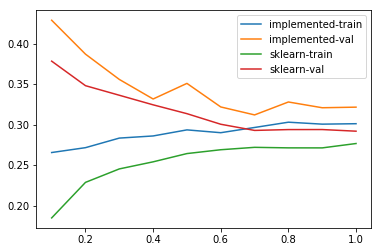


________Result discussion________
Here result is as expected. Observing the implemented-train and sklearn-train 
are diminishing in at the same rate and in the same direction. 
Since Sklearn LinearRegression.fit is implemented using OLS this result
in an optimal solution. Our implementation is Gradient optimizing base
therefore, our MSE score is higher.



In [599]:
#Sanity check
X_train_ = np.random.rand(1000,10)
y_train_ = np.random.rand(1000)
a, b =learning_curve(Linear_Regression(), X_train_, y_train_, 5, 
                     learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0)
print(a, b)

plt.plot(np.linspace(0.1, 1.0, 10),a, label='implemented-train')
plt.plot(np.linspace(0.1, 1.0, 10),b, label='implemented-val')

from sklearn import linear_model
a, b = learning_curve(linear_model.LinearRegression(), X_train_, y_train_, 5, 
                      learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0)
plt.plot(np.linspace(0.1, 1.0, 10),a, label='sklearn-train')
plt.plot(np.linspace(0.1, 1.0, 10),b, label='sklearn-val')
plt.legend()
plt.show()

print('''
________Result discussion________
Here result is as expected. Observing the implemented-train and sklearn-train 
are diminishing in at the same rate and in the same direction. 
Since Sklearn LinearRegression.fit is implemented using OLS this result
in an optimal solution. Our implementation is Gradient optimizing base
therefore, our MSE score is higher.
''')

Implemented MSE 0.15025990468499884
SKlearn MSE  0.08727569302515481


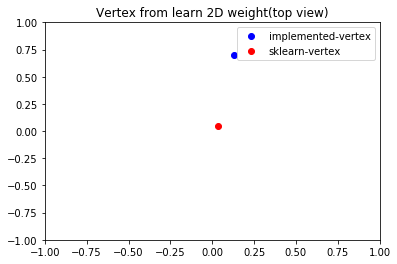

In [609]:
#Sanity check
X_train_ = np.random.rand(1000,2)
y_train_ = np.random.rand(1000)

X_val_ = np.random.rand(5,2)
y_val_ = np.random.rand(5)

LR = Linear_Regression()

# mean_dim = np.mean(X_train_, axis=0)
# std_dim = np.std(X_train_, axis=0)

# X_train_ = (X_train_ - mean_dim)/std_dim

loss_hist = LR.fit(X_train_, y_train_, learning_rate=1e-1, 
                   epochs=100, regularizer='l2',
                   lambd=0.0001)
pred_implemented = LR.predict(X_val_)

LR_sklearn = linear_model.SGDRegressor(loss='squared_loss',penalty='l2',tol=1e-2, 
                                       alpha=1e-1, max_iter=100)
_ = LR_sklearn.fit(X_train_, y_train_)
pred_sk = LR_sklearn.predict(X_val_)

print('Implemented MSE', mse(pred_implemented, y_val_))
print('SKlearn MSE ',mse(pred_sk, y_val_))

plt.title("Vertex from learn 2D weight(top view)")
plt.plot(LR.params['w'][0], LR.params['w'][1], 'bo', label='implemented-vertex')
plt.plot(LR_sklearn.coef_[0], LR_sklearn.coef_[1], 'ro', label='sklearn-vertex')
plt.legend()
plt.ylim((-1,1))
plt.xlim((-1,1))
plt.show()

In [610]:
#this check tell how frequen does our metrics got off base on sklearn
def syn_prob(time=100):
    implement_win = 0
    sklearn_win = 0
    avg_diff = 0.0
    for t in range(time):
        X_train_ = np.random.rand(1000,2)
        y_train_ = np.random.rand(1000)

        X_val_ = np.random.rand(5,2)
        y_val_ = np.random.rand(5)

        LR = Linear_Regression()

        # mean_dim = np.mean(X_train_, axis=0)
        # std_dim = np.std(X_train_, axis=0)

        # X_train_ = (X_train_ - mean_dim)/std_dim

        loss_hist = LR.fit(X_train_, y_train_, learning_rate=1e-1, 
                           epochs=100, regularizer='l2',
                           lambd=0.0001)
        pred_implemented = LR.predict(X_val_)

        LR_sklearn = linear_model.SGDRegressor(loss='squared_loss',penalty='l2',tol=1e-2, 
                                               alpha=1e-1, max_iter=100)
        _ = LR_sklearn.fit(X_train_, y_train_)
        pred_sk = LR_sklearn.predict(X_val_)

        iml = mse(pred_implemented, y_val_)
        skl = mse(pred_sk, y_val_)
        if iml < skl: 
            implement_win+=1 
        else: 
            sklearn_win+=1 
            avg_diff += abs(abs(iml) - abs(skl) )/ abs(iml)*100
            
    print("Implemented win", implement_win/time,'%oftimes', ' with avg_diff', avg_diff/sklearn_win, '%')
    print("Sklearn win", sklearn_win/time)

syn_prob(time=100)

Implemented win 0.24 %oftimes  with avg_diff 41.14431846502648 %
Sklearn win 0.76


# B. Data processing
### 6. Read in white wine portion of the wine quality dataset from UCI's repository

In [616]:
#crane_path = r'/work/cseos2g/datduyn/Documents/datasets/wine-quality/winequality-white.csv'
window_path = r'C:\Users\datng\Documents\datasets\wine-quality\winequality-white.csv'
#crane_path = r'/home/cse496dl/otiong/machineLearning/assignment_1/winequality-white.csv'
# window_path = r'C:\Users\onsai\CSCE478\datasets\DataScienceRepository\winequality-white.csv'

df = pd.read_csv(window_path,delimiter=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### 7. Explore and summarize the dataset 
#### Describe the numerical record

In [618]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,0.665169
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.471979
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,0.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,1.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,1.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,1.000000


### Dimension of data

In [619]:
df.shape

(4898, 12)

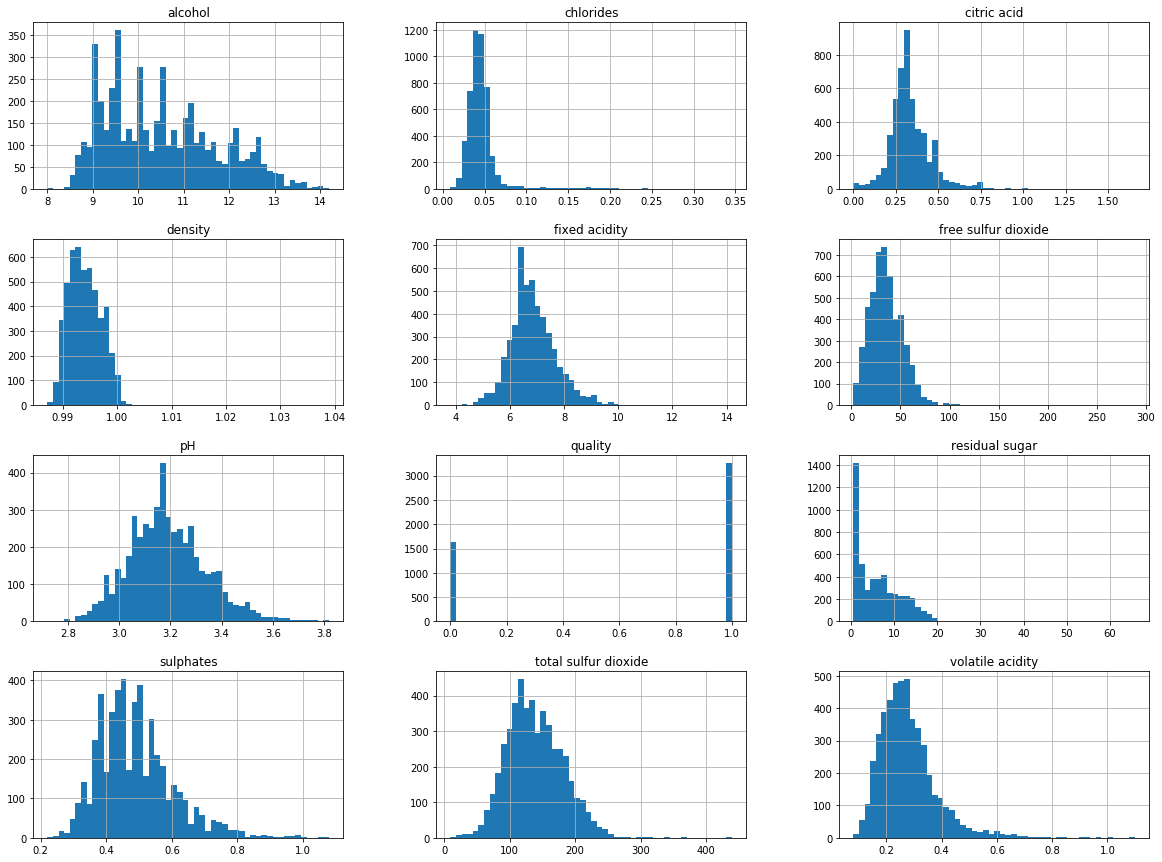

In [620]:
_ = df.hist(bins=50, figsize=(20,15))

### 8. Shuffle data

In [622]:
df = df.sample(frac=1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4158,7.4,0.16,0.30,13.7,0.056,33.0,168.0,0.99825,2.90,0.44,8.7,1
4641,6.6,0.26,0.36,1.2,0.035,43.0,126.0,0.99094,3.01,0.63,11.4,1
4460,6.6,0.18,0.26,17.3,0.051,17.0,149.0,0.99840,3.00,0.43,9.4,1
3961,7.6,0.39,0.46,11.7,0.084,55.0,170.0,0.99773,2.91,0.51,9.0,0
860,8.1,0.27,0.35,1.7,0.030,38.0,103.0,0.99255,3.22,0.63,10.4,1


### 9. Generate pair plot

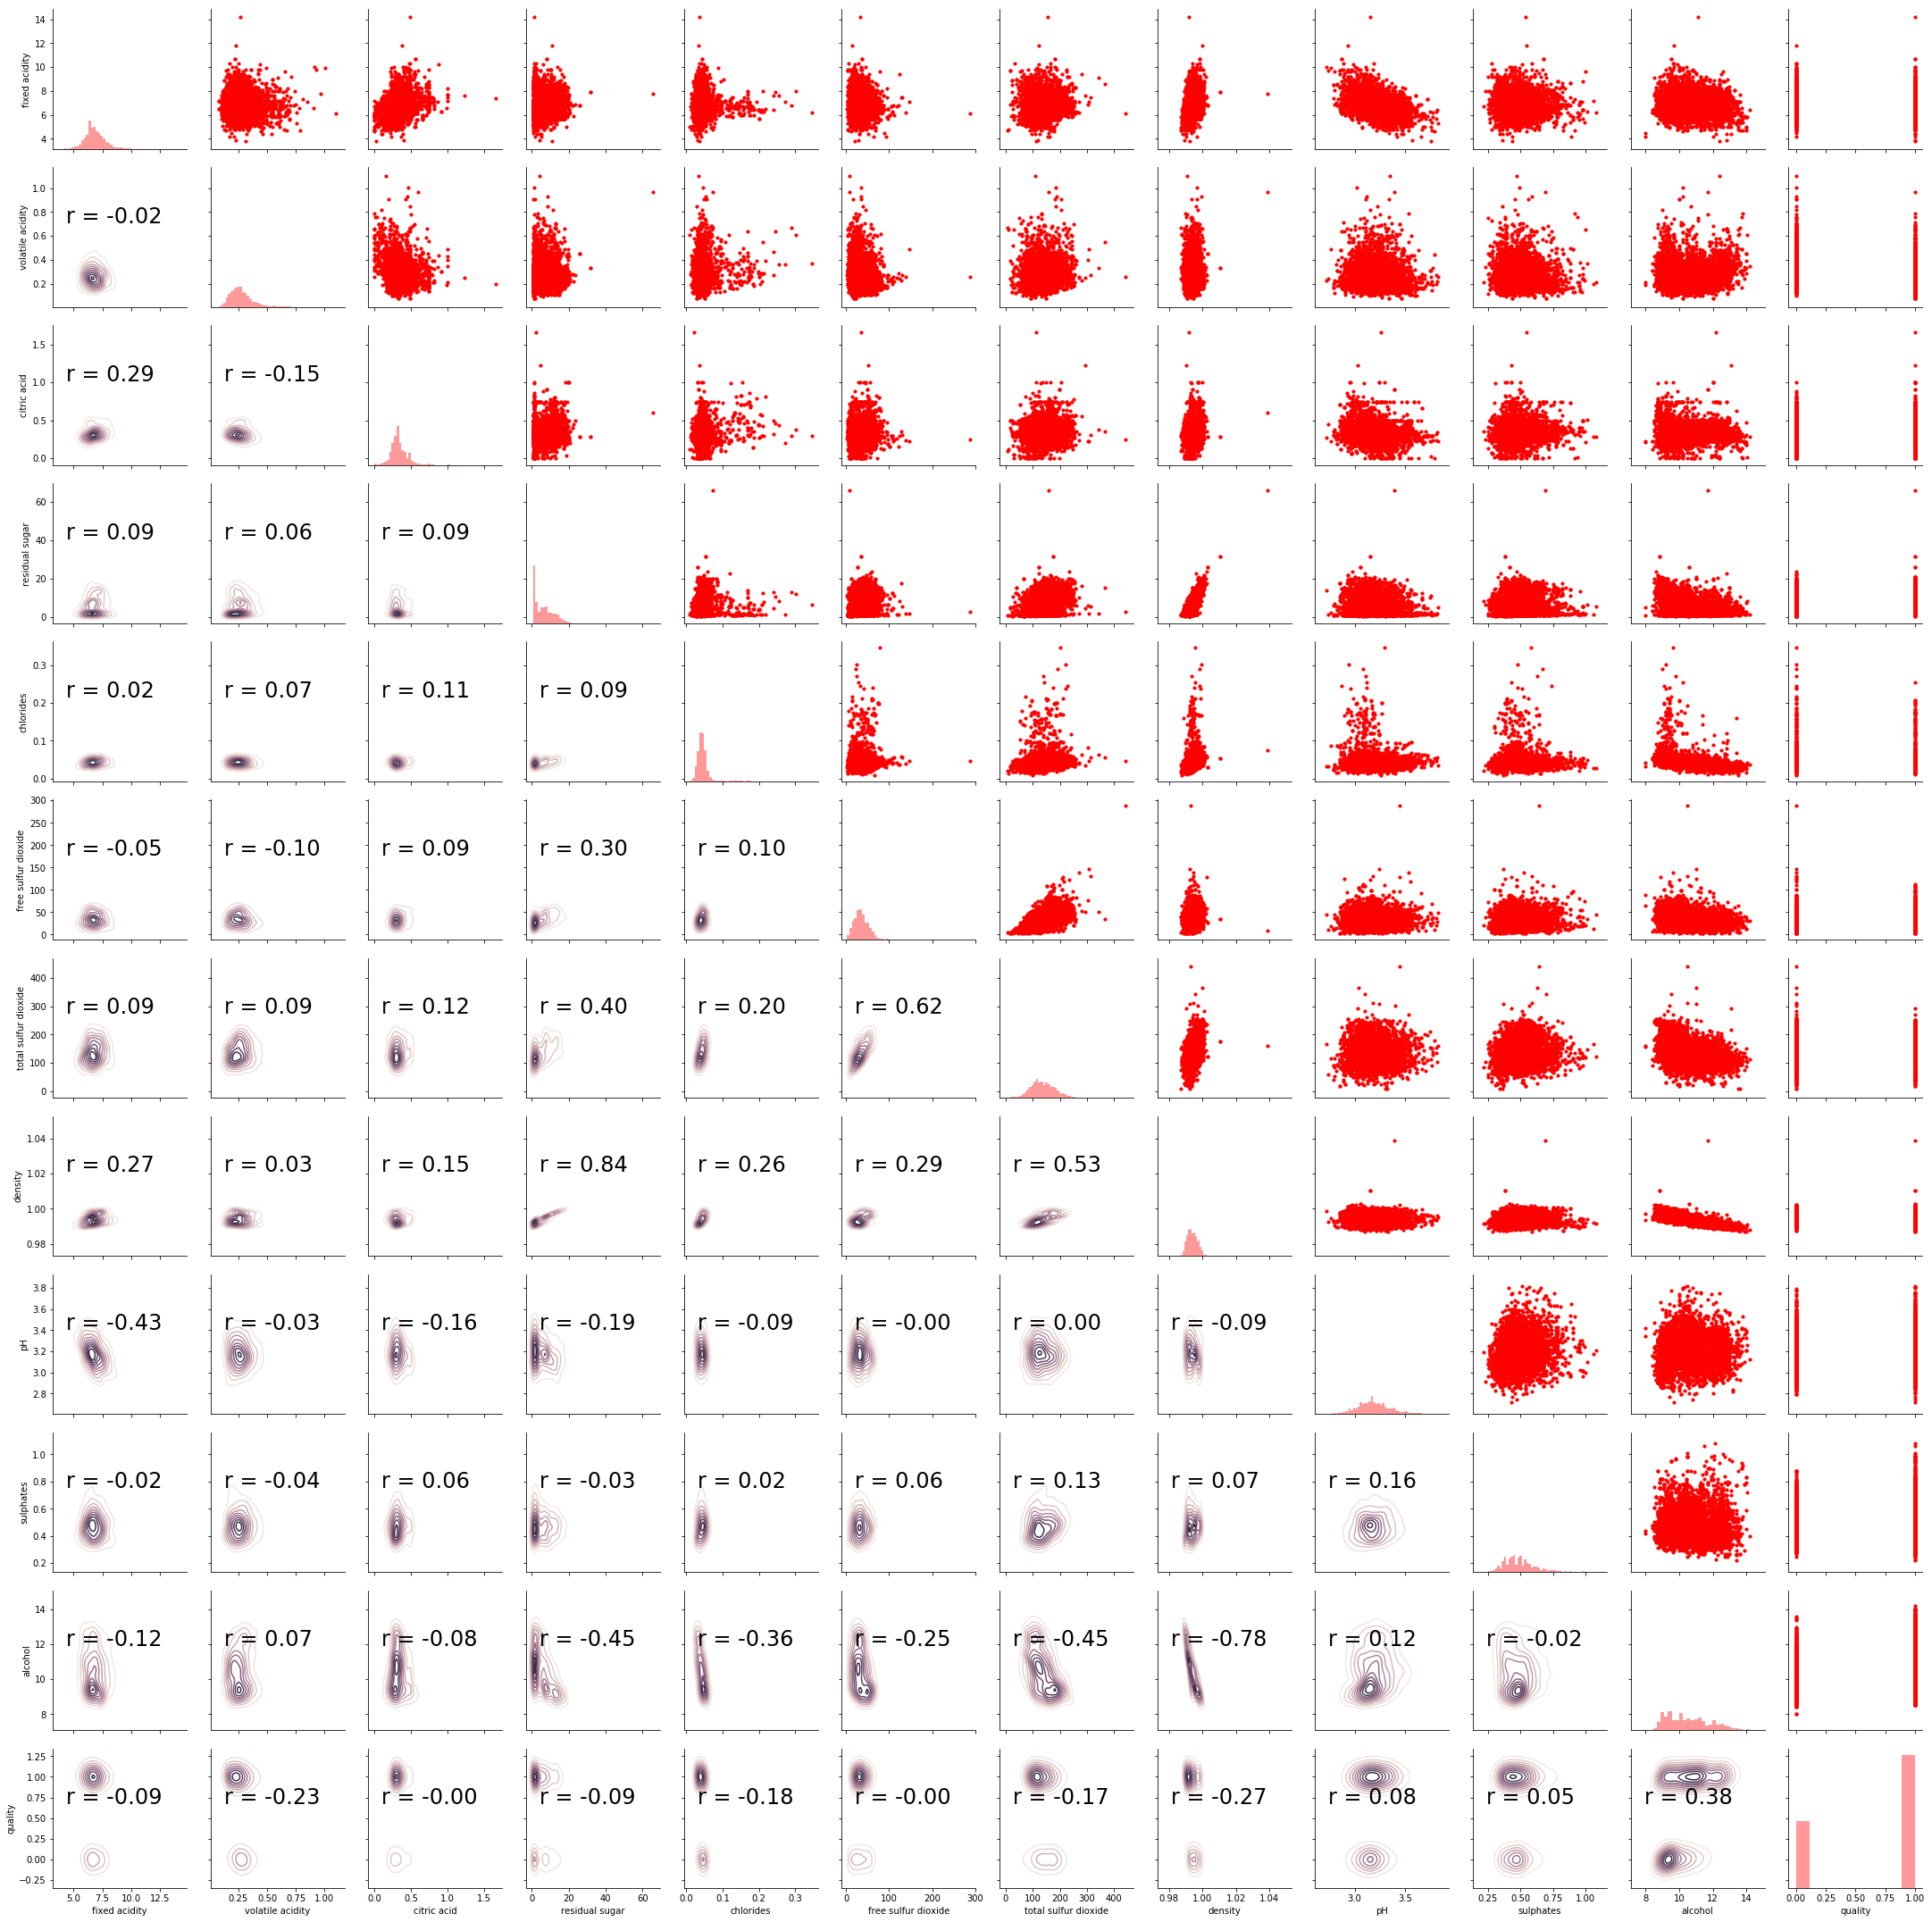

In [623]:
import seaborn as sns
from scipy import stats

# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

### 10. Write a function to split to train and test

#### Create dataset

In [625]:
y = df['quality']
X = df.drop('quality', axis=1)

print("X shape:", X.shape)
print("y shape:",y.shape)

X shape: (4898, 11)
y shape: (4898,)


In [626]:
def split_train_test(X, y, 
                     partition_percent=[.8,.2], shuffle=False):
    '''
    Partioning the data:
    args:
        - X: train set numpy or dataframe with shape(N,D)
        - y: labels numpy or dataframe with shape(N,)
        - partition_percent: python list of data percentage
         to partition. ex: [.8, .2] -> part of data
         will be split to .8 and part will be .2.
         NOTE: have to sum up to 1.0
        - shuffle: shuffle before partitioning or not?
    '''
    
    #convert from panda series to numpy
    try:
        X = X.as_matrix()
        y = y.as_matrix()
    except: #incase given X, y is already a numpy arra
        pass
    
    N = X.shape[0]
    if(sum(partition_percent) != 1.0):
        raise ValueError("Partition_percent should add up to 1.0")
    if shuffle:
        X = np.random.shuffle(X)
    
    split_sets = []
    s = [] #[X1,y1, X2, y2, X3, y3...]
    prev_idx = 0
    for idx,part in enumerate(partition_percent):
        range_idx = int(N * part)
        if(idx == len(partition_percent)-1):
            split_sets.append(X[prev_idx:])
            split_sets.append(y[prev_idx:])
        else:
            split_sets.append(X[prev_idx:prev_idx+range_idx])
            split_sets.append(y[prev_idx:prev_idx+range_idx])
        prev_idx = prev_idx+range_idx
        
    return split_sets

In [627]:
X_train, y_train, X_test, y_test= split_train_test(X, y, 
                partition_percent=[.8,.2], 
                shuffle=False)

#create dev set for debuging
X_dev = X_train[0:10].copy()
y_dev = y_train[0:10].copy()

# Check shape
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

print("X_dev",X_dev.shape)
print("y_dev",y_dev.shape)

X_train (3918, 11)
y_train (3918,)
X_test (980, 11)
y_test (980,)
X_dev (10, 11)
y_dev (10,)


## Part C: Model Evaluation

In [630]:
def kFold(folds, data, labels, model, model_args, error_function=mse):
    x_train_folds = np.array(np.array_split(X_train, folds))
    y_train_folds = np.array(np.array_split(y_train, folds))
    
    best_score = 0.
    best_model = None
    book_keeping = {}
    book_keeping['expected_labels'] = []
    book_keeping['predicted_labels'] = []
    model_score = 0. #this val will be average out between folds
    
    for idx, val_fold in enumerate(x_train_folds):
        train_folds = [f for i, f in enumerate(x_train_folds) if(i != idx)][0] #[0]: unpacking the outer list
        label_folds = [f for i, f in enumerate(y_train_folds) if(i != idx)][0]

        #eval the model on val and train on train_folds
        model.fit(X=train_folds, Y=label_folds, learning_rate=model_args['learning_rate'], 
                   epochs=300, tol=None, regularizer=model_args['regularizer'],
                   lambd=model_args['lambd'], verbose=False)
        
        val_pred = model.predict(val_fold)
        model_score += error_function(val_pred, y_train_folds[idx]) #label_fold'
        book_keeping['expected_labels'].append(y_train_folds[idx])
        book_keeping['predicted_labels'].append(val_pred)

    return {
        'expected_labels': np.array(book_keeping['expected_labels']).ravel(),
        'predicted_labels': np.array(book_keeping['predicted_labels']).ravel(),
        'avg_scores': model_score/folds
    }

In [628]:
args = {}


In [629]:
args['sdf']

KeyError: 'sdf'